# StatLineTable plot voorbeeld

Hier geven we een voorbeeld hoe je makkelijk met een Python script data van OpenData (StatLine) kan halen en een plot kan maken in de CBS huisstijl. 

We maken gebruik van de *StatLineTable* klasse uit de *cbs_utils.readers* module. Deze klasse is een toevoeging op de *cbsodata* module (het maakt voor het inlezen gebruik van *cbsodata*). Met *StatLineTable* kan je de data in een gestructureerde pandas dataframe stoppen, zodat het bewerken en plotten een stuk eenvoudiger gaat.

We delen dit voorbeeld op in vier secties:

1. [*Inlezen*](#inlezen): Inlezen van de OpenData Tabel
2. [*Analyse*](#analyse): Analyse van de stuctuur van de OpenData Tabel
3. [*Dumpen*](#dumpen): Het wegschrijven van de plaatjes van *alle* vragen
4. [*Plotten*](#plot_een_vraag): Een mooie plot van één vraag uit de statline tabel

We beginnen met het inladen van de benodigde modules en het initialiseren van de logger

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import sys
from cbs_utils.misc import (create_logger, merge_loggers)
from cbs_utils.plotting import (CBSPlotSettings, add_axis_label_background)
from cbs_utils.readers import StatLineTable

In [2]:
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger()

<a id=inlezen></a>

## Inlezen van een OpenData Tabel

Het inladen van een tabel uit opendata is eenvoudig. We moeten eerst de ID van een tabel vinden door naar statline te gaan en je tabel te openen. Bijvoorbeeld, het ICT gebruik van bedrijven in 2018 naar bedrijfsgrootte staat in deze tabel

https://opendata.cbs.nl/#/CBS/nl/dataset/84410NED/table?ts=1568706226304

Dit betekent dat de tabel ID '84410NED' is. Deze gaan we nu inlezen

In [3]:
%%time
table_id = "84410NED"
logger.info(f"Start met het lezen van tabel {table_id}")

statline = StatLineTable(table_id=table_id)

INFO : Start met het lezen van tabel 84410NED
INFO : Importing table 84410NED and store to cache/84410NED
INFO : Setting 'use_https' changed from 'undefined' to 'True'.
INFO : Setting 'api_version' changed from 'undefined' to '3'.
INFO : Download https://opendata.cbs.nl/ODataFeed/odata/84410NED/?%24format=json
INFO : Download https://opendata.cbs.nl/ODataFeed/odata/84410NED/TableInfos?%24format=json
INFO : Download https://opendata.cbs.nl/ODataFeed/odata/84410NED/TypedDataSet?%24format=json
INFO : Download https://opendata.cbs.nl/ODataFeed/odata/84410NED/DataProperties?%24format=json
INFO : Download https://opendata.cbs.nl/ODataFeed/odata/84410NED/CategoryGroups?%24format=json
INFO : Download https://opendata.cbs.nl/ODataFeed/odata/84410NED/Bedrijfsgrootte?%24format=json
INFO : Reading json cache/84410NED/DataProperties.json
INFO : Reading json cache/84410NED/TypedDataSet.json
INFO : Reading json cache/84410NED/TableInfos.json
INFO : Merging all the dataframes
INFO : Writing to pickle 

Je ziet dat er 'under the hood' een hoop gebeurt:
1. Het laden van de data wordt door de *cbsodata* module afgehandeld. Deze module slaat de data op in verschillende json file. 
2. Vervolgens worden deze json files samengevoegd tot een multi-index pandas Dataframe. 
3. We slaan de data frames op in een pickel file (standaar binary python file). De volgende keer als je dezelfde plot maakt zullen de pickel files ingelezen worden. Dit gaat veel sneller dan de de data nog een keer met *cbsodata* van het internet te downloadedn. Het maakt het ontwikkelen van een script een stuk gemakkelijker.
4. We slaan de structuur van de tabel op in wat txt files: QuestionTable bevat alle vragen, SectionTable alle modules. Deze data files kan je gebruiken om snel op te zoeken welk nummer je moet gebruiken om een vraag te plotten
    
De eerste keer dat we de script draaide duurde het zo'n 7 seconden, de tweede keer een fractie van een seconde. Dit tijdsvoordeel is vooral prettig als je de script vaak herdraait om een plaatje te 'tunen'

<a id=analyse></a>

## De structuur van de opendata tabel in StatLineTable

Als volgende stap gaan we bekijken hoe de data structuur van de vragenlijst eruit ziet. Zoals gezegd, dit kan je ook zien door de inhoud van QuestionTable.txt in the image directory te bekijken. Maar we kunnen het ook direct opvragen:

In [4]:
statline.show_module_table()

INFO : Structure of all modules
+------+------------+----------------------------------------+
|   ID |   ParentID | Title                                  |
|------+------------+----------------------------------------|
|    1 |            | Personeel en ICT                       |
|    4 |          1 | ICT-specialisten                       |
|    9 |          1 | ICT-beveiliging/bescherming data       |
|   13 |            | Toegang en gebruik internet            |
|   14 |         13 | Bedrijven met website                  |
|   16 |         14 | Website bevat                          |
|   23 |            | Cloud-diensten                         |
|   25 |         23 | Type cloud-diensten                    |
|   33 |         25 | Type server                            |
|   36 |            | Big-data-analyse                       |
|   38 |         36 | Bronnen big data voor analyse          |
|   43 |         36 | Wie analyseerde big data               |
|   46 |            | I

We zien hier een lijst van modules, submodules, en vragen. Een vraag kan weer uit meerder opties (aanvink mogelijkheden) bestaan. Een module heeft in de structuur het hoogste niveau binnen een tabel: heeft is een blok vragen die allen bij één onderwerp horen. Modules in deze lijst kan je herkennen omdat ze geen parentID hebben: ze zijn zelf het hoogst in de hiërarchie. De modules in deze tabel zijn dus: 
* 1: Personeel en ICT
* 13: Toegang en gebruik internet 
* 23: Cloud-diensten
* 36: Big-data-analyse
* 46: ICT-veiligheid
* 83: Facturen
* 97: E-commerce in 2017

Een module heeft als volgende niveau *of* een vraag *of* een submodule. Dit kunnen we zien door de structuur van de hele vragenlijst te printen. Dit doen we als volgt: 

In [5]:
statline.show_question_table(max_width=23)

INFO : Structure of all questions
+-------------------------------+-------------------------+-------------------------+-------------------------+
|                               | Key                     | Title                   | Unit                    |
|-------------------------------+-------------------------+-------------------------+-------------------------|
| (1, 2, nan, nan, nan)         | ICTPersAangenomenWillen | ICT-pers. aangenomen/wi | % van bedrijven         |
| (1, 3, nan, nan, nan)         | ICTVacaturesLastigTeVer | ICT-vacatures lastig te | % van bedrijven         |
| (1, 4, 5.0, nan, nan)         | ICTSpecialistenInLoondi | ICT-specialisten in loo | % van werkzame personen |
| (1, 4, 6.0, nan, nan)         | ICTSpecOntwEnOnderhoudS | ICT-spec. ontw. en onde | % van werkzame personen |
| (1, 7, nan, nan, nan)         | ICTCursusAanICTSpeciali | ICT-cursus aan ICT-spec | % van bedrijven         |
| (1, 8, nan, nan, nan)         | ICTCursusAanOverigPerso | ICT-cursus

De eerste kolom geeft de ID van de vragen en de positie in de hierchie van de tabel. We zien in de eerste tabel dat de module 46 (ICT-veiligheid) als eerste een vraag heeft, namelijk 47 (gebruikte ICT maatregelen), en dat deze vraag 47 weer twaalf onderdelen heeft, namelijk optie 48 tot en met 59, die allemaal als ParentID 47 hebben. Dit is een voorbeeld van een vraag op niveau 1 (als we het module niveau als niveau 0 zien), met de opties op niveau 2. 

Uit de eerste tabel zien we dat E-commerce (ID 97) als eerste een submodule bevat, 98 (gebruikt voor verkoop). Dit zien we omdat in de tweede tabel, 98 nooit aan een variabele toegekent wordt. Het is 99 (Verkoop via e-commerce) dat de eerste stanalone vraag is die een parent 98 heeft. Daarom dat deze vraag, die in een submodule zit, op niveau 2 komt. De Volgende vraag 100 is weer een vraag met optie. De vraag 100 is in de eerste tabel terug te vinden (Verdeling omzet: eigen site of extern), maar omdat deze vraag weer optie heeft, zitten deze optie weer op niveau 3: 101 en 102.

Deze structuur zit wel in de json files beschreven, maar StatLineTable maakt er een multi-index pandas data frame van, zodat je makkelijk de vragen en modules die bijelkaar horen kan processen (dit in tegenstelling tot de pandas dataframe die door *cbsodata* geretourneerd wordt. Dit is  gewoon een platte lijst van variables, waardoor het lastig wordt om de vragen die bijelkaar horen te groeperen. 

Naast het aanbrengen van structuur, zorgt StatLineTable er ook voor dat de volledige beschrijving van een variable en de eenheden in de pandas DataFrame terug te vinden zijn (in respectievelijk de 2de en 3de kolom).

Het belangrijkste wat je hier moet weten is hoe je kan opzoeken welke ID bij welke module wordt, zodat je deze nummers later kan gebruiken om een selectie van modules te maken.  

<a id=dumpen></a>

## Dumpen van plaatjes van alle vragen uit de tabel

Bovenstaande klinkt misschien complex, maar het doel van StatLineTable is juist om het eenvoudiger te maken een plaatje van de vragen te maken. Het maken van plaatjes kan dus intern door StatLineTable gedaan worden. Deze plaatjes zijn met default settings opgemaakt, dus het is niet geschikt voor publicatie, maar vooral voor een snelle blik op al je data in de tabel. Het maken van plaatjes van al je vragen gaat als volgt:

INFO : Reading json cache/84410NED/DataProperties.json
INFO : Reading json cache/84410NED/TypedDataSet.json
INFO : Reading json cache/84410NED/TableInfos.json
INFO : Reading from pickle database cache/84410NED_question.pkl
INFO : Reading from pickle database cache/84410NED_section.pkl
INFO : Reading from pickle database cache/84410NED_dimensions.pkl
INFO : Writing table information to images/84410NED/TableInfos.yml
INFO : Writing question structure to images/84410NED/QuestionTable.txt
INFO : Writing question structure to images/84410NED/SectionTable.txt
INFO : Processing module 1:


/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


INFO : Processing module 46:


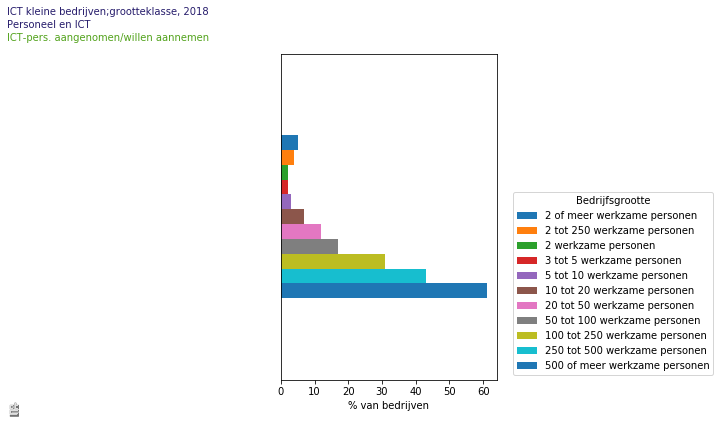

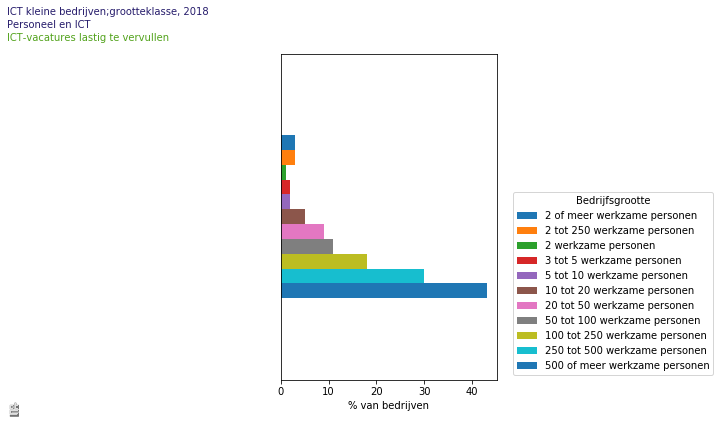

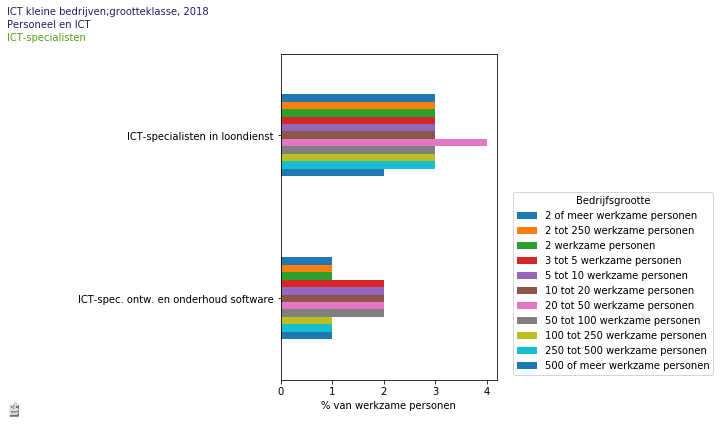

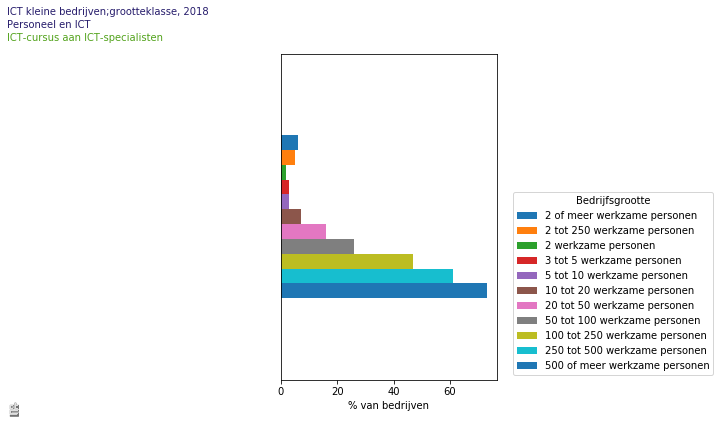

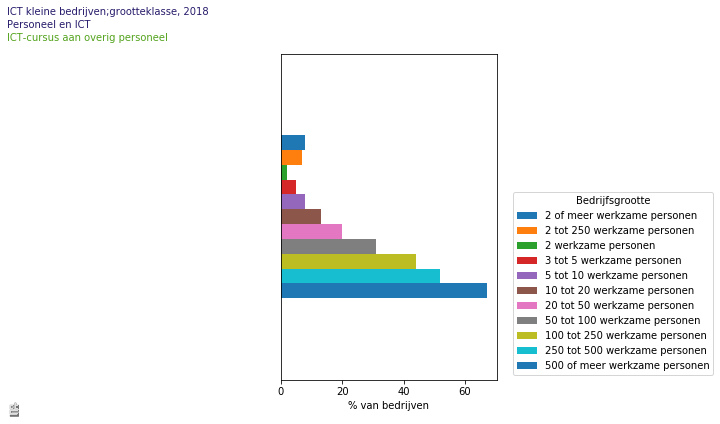

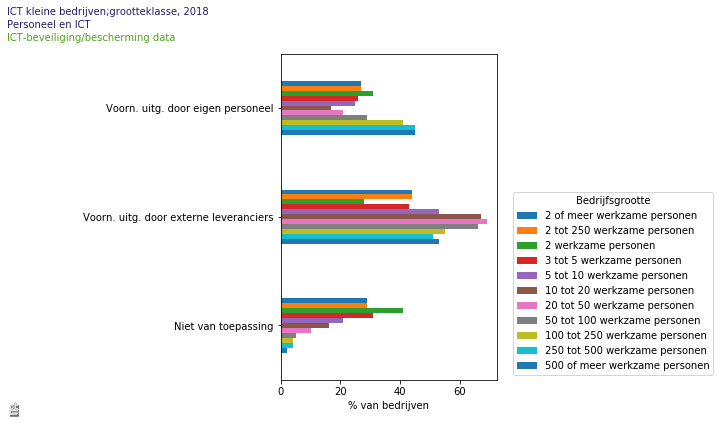

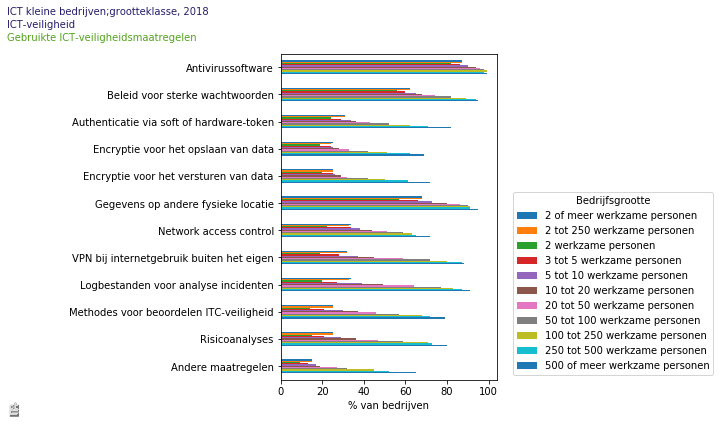

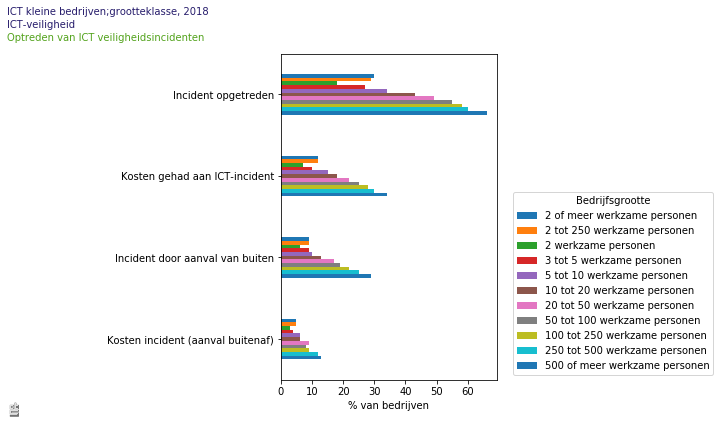

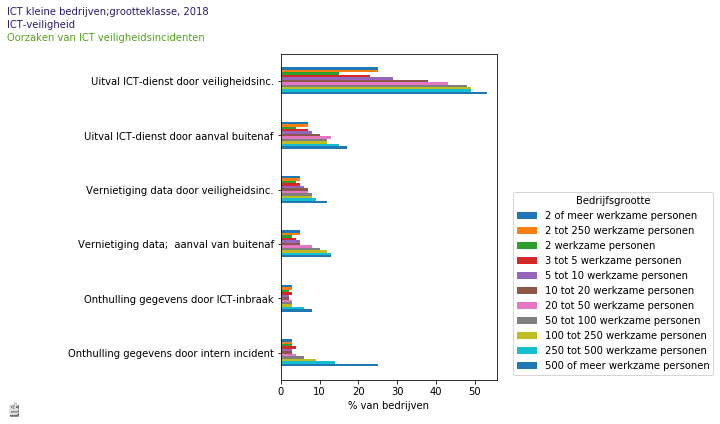

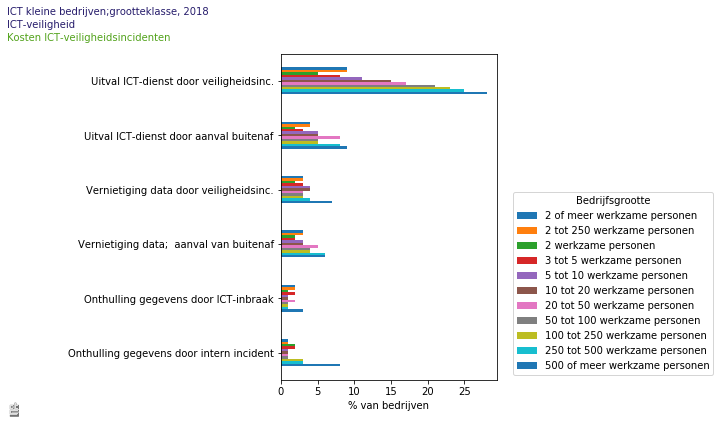

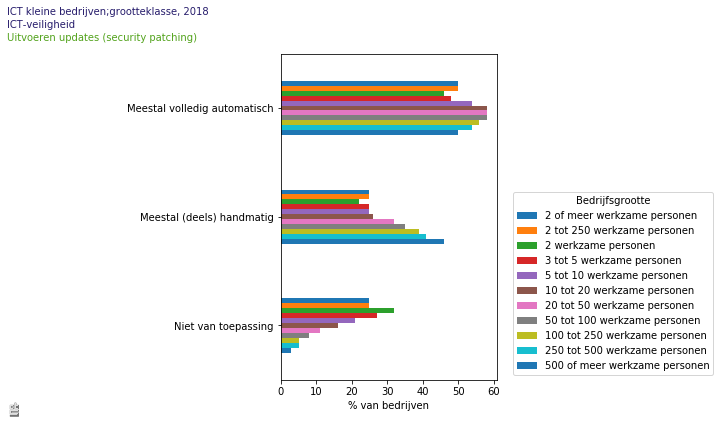

In [6]:
statline = StatLineTable(table_id=table_id, make_the_plots=True, modules_to_plot=[1, 46])

Nadat we klaar zijn hebben we een plaatje van 11 vragen geplot. Dit is niet alles, omdat we een lijst van modules die we willen plotten hebben meegegeven: 1 (Personeel en ICT) en 46 ICT-veiligheid. De nummers die je aan de lijst meegeeft hebben we in de eerste tabel boven terug kunnen vinden door het runnen van de *show_module_table* method (waar de modules de items zijn die *geen* *ParentID* hebben). Als de het argument *modules_to_plot* niet meegegeven hadden, dan hadden we een dump alle vragen gemaakt. Dat doen we hier maar even niet omwille van het beperken van de uitvoer.

Als je de plaatjes als png wilt saven dan  moet je de optie *save_plot=True* meegeven. Dan kan je de plaatjes terug vinden in de directory *images/84410NED*, welke automatisch aangemaakt wordt mocht deze nog niet bestaan. 

<a id=plot_een_vraag></a>

## Het plotten van een CBS grafiek voor één vraag

Het dumpen van de vragen als plots is handig om een overzicht van je data te krijgen, maar echt mooi zijn de plots niet. Dit komt omdat we de layout niet getuned hebben, en bovendien omdat voor iedere vraag de waardes voor alle grootteklasses geplot is. We gaan nu laten zien hoe we de data van één vraag kunnen plotten voor een selectie van grootteklases. 

### Klaar maken van de plot data 

Eerst willen we kijken welke grootteklasses we allemaal tot ons beschikking hebben. We doen dit als volgt:

In [7]:
statline.show_selection()

INFO : You can make a selection from the following values
Index(['2 of meer werkzame personen', '2 tot 250 werkzame personen',
       '2 werkzame personen', '3 tot 5 werkzame personen',
       '5 tot 10 werkzame personen', '10 tot 20 werkzame personen',
       '20 tot 50 werkzame personen', '50 tot 100 werkzame personen',
       '100 tot 250 werkzame personen', '250 tot 500 werkzame personen',
       '500 of meer werkzame personen'],
      dtype='object', name='Bedrijfsgrootte')


De waardes van deze grootteklasses worden aan de *selection_option* attribute toegevoegd. Stel dat we voor de plot alleen de grootteklasses 2, 20 tot 50, en 500 of meer werkzame personen willen laten zien dan moeten we dus respectievelijk het 3de (index=2), 7de (index=6) en laatste (index=-1) item hebben. Laten we deze waardes er eens uit plukken:

In [8]:
selection = [statline.selection_options[2],
             statline.selection_options[6],
             statline.selection_options[-1]]
logger.info(f"We hebben de volgende grootteklasses geselecteerd:\n{selection}")

INFO : We hebben de volgende grootteklasses geselecteerd:
['2 werkzame personen', '20 tot 50 werkzame personen', '500 of meer werkzame personen']


We hadden  bij het initialiseren van de StatLineTable klasse deze selectie als argument mee kunnen geven als *selection=selection*, met daarnaast ook nog de *apply_selection=True* flag meegegeven. Maar in Python kan je de waardes ook nog achteraf toekennen. Laten we dat nu doen:

In [9]:
statline.selection = selection
statline.apply_selection = True

Doordat we de selectie aan de *selection* attribute hebben toegekend, zullen we dadelijk bij het reorganiseren van de data alleen nog de waardes van deze grootteklasses krijgen. 

Voor het opvragen van een dataframe voor één vraag kunnen we de *get_question_df* method gebruiken. Bijvoorbeeld, stel we willen vraag met ID 47 plotten. Aan de eerste tabel die we met *show_module_table* lieten zien vinden we terug dat deze vraag hoort bij de vraag *Gebruikte ICT-veiligheidsmaatregelen*. Verder liet de 2de tabel die we met *show_question_table* maakten zien dat deze vraag 12 keuze mogelijkheden had. We trekken nu als volgt de vraag uit de tabel:

In [10]:
question_df = statline.get_question_df(47)
question_df.head(12)  # dit laat de eerste twaalf rijen uit de data frame zien

,,,Section,ID,ParentID,Key,Title,Description,Datatype,Unit,Decimals,Default,Bedrijfsgrootte,Bedrijfsgrootte_Key,Values
L2,L3,L4,,,,,,,,,,,,,
48,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,48,47,Antivirussoftware_34,Antivirussoftware,Het gebruikt van antivirussoftware betreft zow...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,87
49,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,49,47,BeleidVoorSterkeWachtwoorden_35,Beleid voor sterke wachtwoorden,Wachtwoorden die ten minste acht gemengde kara...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,62
50,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,50,47,AuthenticatieViaSoftOfHardwareToken_36,Authenticatie via soft of hardware-token,Identificatie en authenticatie van gebruikers ...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,31
51,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,51,47,EncryptieVoorHetOpslaanVanData_37,Encryptie voor het opslaan van data,Versleutelingstechnieken (encryptie) voor het ...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,25
52,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,52,47,EncryptieVoorHetVersturenVanData_38,Encryptie voor het versturen van data,Versleutelingstechnieken (encryptie) voor het ...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,25
53,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,53,47,GegevensOpAndereFysiekeLocatie_39,Gegevens op andere fysieke locatie,Op een andere fysieke locatie (reserve)gegeven...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,68
54,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,54,47,NetworkAccessControl_40,Network access control,Alleen apparaten die voldoen aan bepaalde eise...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,34
55,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,55,47,VPNBijInternetgebruikBuitenHetEigen_41,VPN bij internetgebruik buiten het eigen,Virtual private network (VPN) bij internetgebr...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,32
56,NaN,NaN,ICT-veiligheid\nGebruikte ICT-veiligheidsmaatr...,56,47,LogbestandenVoorAnalyseIncidenten_42,Logbestanden voor analyse incidenten,Logbestanden opslaan om incidenten achteraf te...,Integer,% van bedrijven,0,Zero,2 of meer werkzame personen,WP19115,34


De eerste twaalf regels van de dataframe laten zien dat we nog alle grootteklasse in de Dataframe terugvinden (we beginnen immers met de 2 of meer werknemers items). In totaal moeten we dus 12 * 11 = 132 in de dataframe hebben. Dit kunnen we met info zien

In [11]:
question_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 132 entries, (48, nan, nan) to (59, nan, nan)
Data columns (total 13 columns):
Section                132 non-null object
ID                     132 non-null object
ParentID               132 non-null object
Key                    132 non-null object
Title                  132 non-null object
Description            121 non-null object
Datatype               132 non-null object
Unit                   132 non-null object
Decimals               132 non-null object
Default                132 non-null object
Bedrijfsgrootte        132 non-null object
Bedrijfsgrootte_Key    132 non-null object
Values                 132 non-null int64
dtypes: int64(1), object(12)
memory usage: 14.9+ KB


Inderdaad hebben we 132 entries. Voordat we de dataframe klaar maken om te plotten, slaan we eerst even de eenheden van de data op. Deze moet als het goed is voor alle entries hetzelfde zijn omdat ze allemaal bij dezelfde vraag horen. Dus we doen

In [12]:
units = question_df[statline.units_key].values[0]
logger.info(f"De eenheden zijn: {units}")

INFO : De eenheden zijn: % van bedrijven


Inderdaad, de vraag voor gebruikte ICT veiligheids maatregelen heeft % van bedrijven. 

Als laatste stap voordat we gaan plotten, gaan we de data frame reorgiseren:

In [13]:
question_df = statline.prepare_data_frame(question_df)

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2874: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [14]:
question_df.head(12)

Bedrijfsgrootte,2 werkzame personen,20 tot 50 werkzame personen,500 of meer werkzame personen
Title,,,
Antivirussoftware,82,96,99
Beleid voor sterke wachtwoorden,56,74,95
Authenticatie via soft of hardware-token,24,43,82
Encryptie voor het opslaan van data,19,33,69
Encryptie voor het versturen van data,20,32,72
Gegevens op andere fysieke locatie,57,86,95
Network access control,22,51,72
VPN bij internetgebruik buiten het eigen,19,59,88
Logbestanden voor analyse incidenten,20,64,91


Door het runnen van *prepare_data_frame* wordt de selectie die we eerder aan de *selection* attribute toegekend hebben uitgevoerd, en bovendien worden de grootteklasses nu als kolommen weergeven. Deze data frame is geschikt om te plotten.

### Het maken van de CBS plot



Allereerst kunnen we de plot settings voor een standaard CBS plot makkelijk instellen met de klasse CBSPlotSettings. Deze klasse stelt de figuurgrootte in en kiest het juiste kleurenschema. Dit doen we nu:

Door het laden van de *CBSPlotSettings* klasse wordt het koele kleuren schema gezet. Je kan het warme palet kiezen door de optie *color_palette="warm"* mee te geven, maar je niks meegeeft dan is de default palet *koel*.

In [15]:
plot_settings = CBSPlotSettings()

We hebben de data die we willen plotten dus in de *question_df* dataframe staan. Dit is een standaard *pandas* data frame, dus met het aanroepen van de *plot* method kunnen we al een plaatje maken. Echter, we willen de plot ook gaan tunen. Daarom is het handiger om buiten *pandas* om de figuur en assen te maken en deze aan de *plot* method mee te geven, zodat we de waardes daarna makkelijk kunnen aanpassen. We beginnen dus met het initialiseren van de figure en axis:n

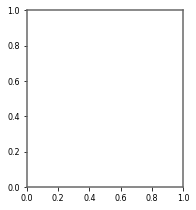

In [16]:
fig, axis = plt.subplots(dpi=72)  # dpi is noodzakelijk om het wegschrijven naar pdf goed te krijgen
fig.subplots_adjust(left=0.5, bottom=0.25, top=0.98)

Dit is nog niet zo spannend. Enige belangrijke is dat we de marges aangepast hebben. We gaan namelijk een horizontale bar plot maken, zodat we aan de linker kant ruimte nodig hebben voor de labels van de staven. Daarom dat we *left=0.5* zetten (0 is vanaf links geen marge, 1 is vanaf links alleen maar marge tot de rechter as, dus 0.5 is een marge die de helft van de plot breedte inneemt. Ook aan de onderkant vergroten we de marge wat omdat we de legend later kwijt moeten. Aan de bovenkant verkleinen we de marge juist. Rechts laten we op de default staan.

We hebben door het gebruik van de *subplots* functie uit de *matplotlib.pyplot* module gelijk toegang tot de figuur en assen. Dus laten we nu de plot method van pandas gebruiken om een horizontale staafdiagram te maken in de assen die we zojuist gemaakt hebben

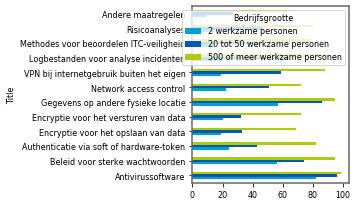

In [17]:

question_df.plot(kind="barh", ax=axis)
fig

We zie dat we inderdaad een liggend bar plot hebben met voldoen ruimte voor de labels links. Ook het kleurenschema is al wat we nodig hebben. Echter, we moeten nog wel wat tunen. We halen eerste de y-as label weg (die is default 'Title') en stellen de x-as label gelijk aan de units die we net opgeslagen hebben in *units*

In [18]:
axis.set_ylabel("")
axis.set_xlabel(units)
axis.xaxis.set_label_coords(0.98, -0.1)

Als default wordt de x-as label in het midden geplaatst. Met de *set_label_coords* method kunnen we deze wat meer naar rechts zetten (de coordinaten zien in fraxies van de assen, links onder is 0,0, rechtboven is 1,1)

Nu gaan we de randen van de assen aanpassen. Deze worden default alle vier getekend, maar we willen alleen de linker rand overhouden. Voor de gridlijnen nemen we alleen de lijnen vanaf de x-grid

In [19]:
for side in ["top", "bottom", "right"]:
    axis.spines[side].set_visible(False)
axis.spines['left'].set_position('zero')
axis.tick_params(which="both", bottom=False, left=False)
axis.xaxis.grid(True)
axis.yaxis.grid(False)

We zien verder dat de x-range iets verder dan 100 doorloopt. Voor percentage willen we dat gewoon op 100 laten eindigen. Dus stel ook de x-range in, maar laat hem tot 101 doorlopen. Dit om te voorkomen dat de laatste gridlijn op 100 wegvalt 

In [20]:
axis.set_xlim([0, 101])

(0, 101)

Een andere eigenaardigheid is dat de items van de bar plot precies andersom geplot worden als dat we in de *question_df* dataframe hadden. Daar hadden we 'Antivirussoftware' op de eerste regel, en 'Andere maatregelen' als laatste, maar dit wordt precies omgekeerd geplot. We draaien dat om met *invert_yaxis*

In [21]:
axis.invert_yaxis()

Ten slotte gaan we de legenda wat aanpassen. Deze is boven op de bar plot gezet. We willen deze aan de onderkant hebben. Daarom doen we:

In [22]:
axis.legend(bbox_to_anchor=(0.01, 0.00), ncol=2, bbox_transform=fig.transFigure, loc="lower left", frameon=False)

Hier volgt een uitleg van de argumenten van de *legend* method:

* De coordinaten die hier met *bbox_to_anchor* gegeven worden zijn ditmaal ten opzichte van de hele figuur (dwz de canvas waar de plot in gemaakt wordt) omdat we *bbox_transform=fig.transFigure* meegeven hebben. Dus 0,0 is helemaal links onder in het hoekje van je bitmap. 
* Zouden we *bbox_transform* niet meegeven dan zou de default transform gekozen worden (axis.transAxes), zodat 0,0 overeen komt met de linker onderhoek van de *assen*. Maar het is handiger om de coordinaten ten opzichte van de figuur te zetten. 
* De *loc='lower left'* optie slaat op het punt van de legenda bounding box dat op de positie van de *bbox_to_anchor* coordinate gezet wordt. Nu is dat dus de linker onderhoek van de hele legend box je referentie punt. Maar als je je box rechts wilt uitlijnen kan het handig zijn om voor *loc* juist de rechter bovenhoek te kiezen.  
* *ncol=2* slaat op het aantal kollom waarin de legend georganiseerd wordt. Default is ncol=1, zodat je een vertikaal rijtje van legend items krijgt. Maar wij willen de items juist naast elkaar. We hebben 3 items, dus met *ncol=2* krijgen we twee rijen: de eerste rij heeft twee lijnen, de tweede rij één.
* De *frameon=False* optie spreekt voor zich: we willen geen box om de legend, dus haal hem eraf

Eens kijken hoe het plaatje er nu uitziet:

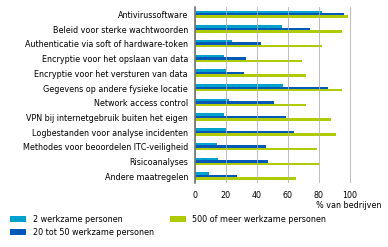

In [23]:
fig

We zijn er bijna. Om er een echt CBS plaatje van te maken willen we de linkerzijde onder de labels nog een grijsvlak met ronde hoekjes plaatsen. Bovendien moet er nog een CBS logo toegevoegd worden. Om dit te doen kan je gebruik maken van de *add_axis_label_background* functie uit de *cbs_utils.plotting* module 

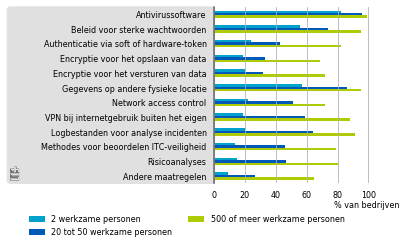

In [24]:
add_axis_label_background(fig=fig, axes=axis)
fig

Hiermee zijn we klaar met de plot. Als je de plot als PDF naar file weg schrijft kan je hem met de beste kwaliteit (namelijk als vectorformaat) in latex inlezen 

In [25]:
fig.savefig("maatregelen.pdf", bbox_inches = 'tight')

De optie *bbox_inches = 'tight'* is alleen in Jupyter notebook noodzakelijk om de marges van de grafiek in de pdf goed te krijgen. Voor een normale script moet je tight juist weg laten omdat het de posities van je labels kan aanpassen.